# PbS spectra and PCA


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sk_pca
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap

from scipy.signal import savgol_filter
import seaborn as sns

Спектры из папки ./data ранее были помещены в один файл pbs.csv, нормированы и дополнены нулями (так как они сняты в разном спектральном диапазоне).

Сделаем два набора - сглаженные данные и сглаженные производные. 

In [2]:
data = pd.read_csv('./data/pbs.csv')

# The last column of the Data Frame contains the labels
lab = data.values[:,-1].astype('uint8') 

# Read the features (scans) 
feat = data.values[:,1:-1]

# Smioothe and calculate first derivative applying a Savitzky-Golay filter
feat = savgol_filter(feat, window_length=5, polyorder=3, deriv=0)
dfeat = savgol_filter(feat, window_length=25, polyorder=3, deriv=1)

Построим спектры, которые планируется анализировать

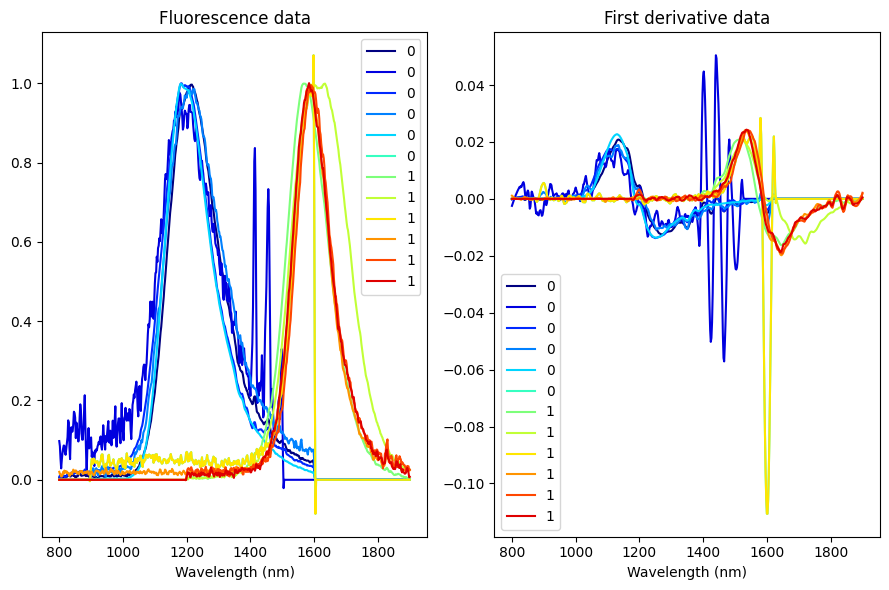

In [3]:
samples = feat.shape[0]
colors = [plt.cm.jet(float(i)/samples) for i in range(samples)]


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
fig.set_tight_layout(True)

x = range(800, 1901, 2)

for i in range(samples):
    col = np.expand_dims(np.array(colors[i]), axis=0)
    ax1.plot(x, feat[i,:], c=col, label=lab[i])
ax1.set_xlabel("Wavelength (nm)")
ax1.set_title('Fluorescence data')
ax1.legend()


for i in range(samples):
    col = np.expand_dims(np.array(colors[i]), axis=0)
    ax2.plot(x, dfeat[i,:], c=col, label=lab[i])
ax2.set_xlabel("Wavelength (nm)")
ax2.set_title('First derivative data')
ax2.legend()

plt.show()

Два спектра в наборе "битые" 5-й и 8-й, ислючим их из рассмотрения, и изобразим повторно (потом для иллюстрации можно этот фрагмент отключить):

In [4]:
data2 = data.drop([5,8])

lab = data2.values[:,-1].astype('uint8') 
feat = data2.values[:,1:-1]

# Calculate first derivative applying a Savitzky-Golay filter
feat = savgol_filter(feat, window_length=5, polyorder=3, deriv=0)
dfeat = savgol_filter(feat, window_length=25, polyorder=3, deriv=1)

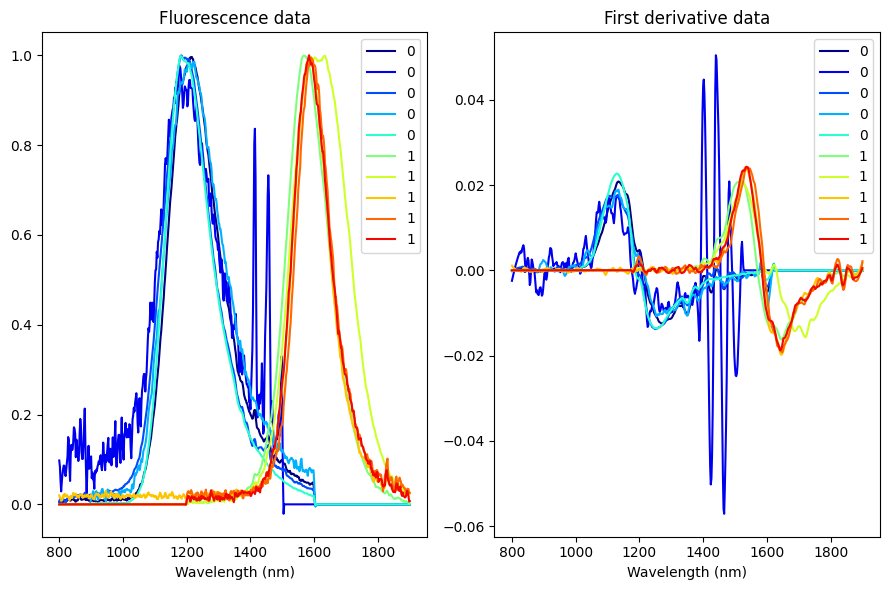

In [5]:
samples = feat.shape[0]
colors = [plt.cm.jet(float(i)/samples) for i in range(samples)]


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
fig.set_tight_layout(True)

x = range(800, 1901, 2)
for i in range(samples):
    col = np.expand_dims(np.array(colors[i]), axis=0)
    ax1.plot(x, feat[i,:], c=col, label=lab[i])
ax1.set_xlabel("Wavelength (nm)")
ax1.set_title('Fluorescence data')
ax1.legend()

for i in range(samples):
    col = np.expand_dims(np.array(colors[i]), axis=0)
    ax2.plot(x, dfeat[i,:], c=col, label=lab[i])
ax2.set_xlabel("Wavelength (nm)")
ax2.set_title('First derivative data')
ax2.legend()

plt.show()

Теперь два набора разбираем на принципиальные компоненты.

In [6]:
# Initialise
skpca1 = sk_pca(n_components=10)
skpca2 = sk_pca(n_components=10)

# Scale the features to have zero mean and standard devisation of 1
# This is important when correlating data with very different variances
nfeat1 = StandardScaler().fit_transform(feat)
nfeat2 = StandardScaler().fit_transform(dfeat)

# Fit the spectral data and extract the explained variance ratio
X1 = skpca1.fit(nfeat1)
expl_var_1 = X1.explained_variance_ratio_
 
# Fit the first data and extract the explained variance ratio
X2 = skpca2.fit(nfeat2)
expl_var_2 = X2.explained_variance_ratio_

Смотрим какое число компонент оптимально для того и другого набора...


Each principal component will explain some of the variation in the data. The first principal component will explain most of the variation, the second a little bit less, and so on. To get a bit more technical, we can talk of variance explained by each principal component. The sum of variances of all principal components is called the total variance.

The general advice is to choose the first nn principal components that account for the large majority of the variance, typically 95% or 90% (or even 85%) depending on the problem. 



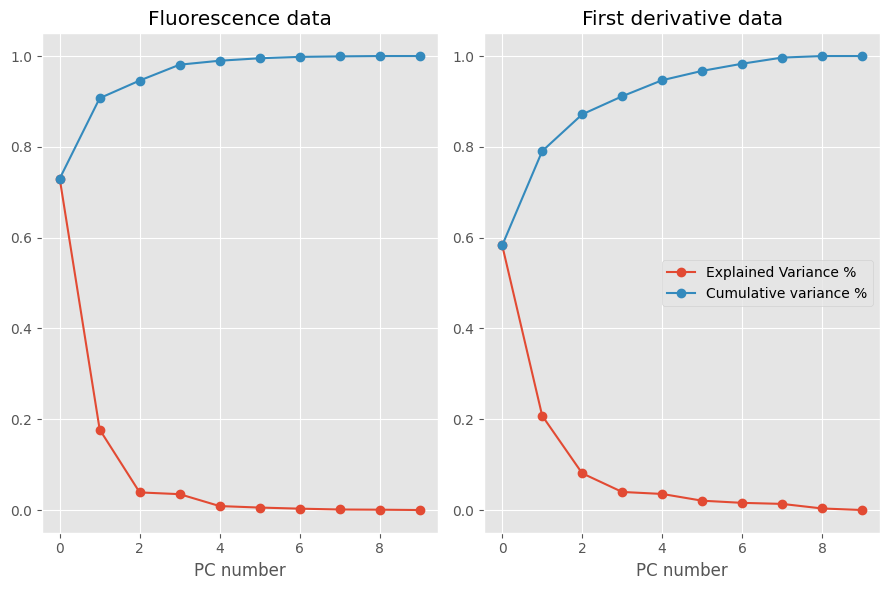

In [7]:
with plt.style.context(('ggplot')):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
    fig.set_tight_layout(True)
 
    ax1.plot(expl_var_1,'-o', label="Explained Variance %")
    ax1.plot(np.cumsum(expl_var_1),'-o', label = 'Cumulative variance %')
    ax1.set_xlabel("PC number")
    ax1.set_title('Fluorescence data')
 
    ax2.plot(expl_var_2,'-o', label="Explained Variance %")
    ax2.plot(np.cumsum(expl_var_2),'-o', label = 'Cumulative variance %')
    ax2.set_xlabel("PC number")
    ax2.set_title('First derivative data')
 
    plt.legend()
    plt.show()

## Classification of  spectra using PCA

Сделал для спектров, но то же самое можно сделать для производной (поменять nfeat1 на nfeat2)

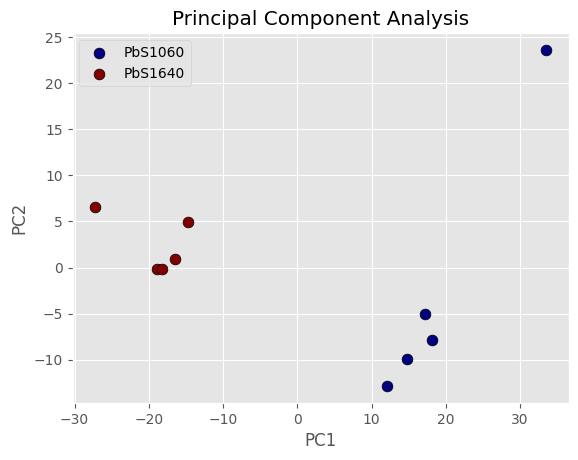

In [8]:
skpca2 = sk_pca(n_components=2) #
 
# Transform on the scaled features
Xt2 = skpca2.fit_transform(nfeat1) # можно подставить nfeat2 и  получить то же самое для производных спектров

# Define the labels for the plot legend
labplot = ["PbS1060","PbS1640"]
 
# Scatter plot
unique = list(set(lab))
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
with plt.style.context(('ggplot')):
    for i, u in enumerate(unique):
        col = np.expand_dims(np.array(colors[i]), axis=0)
        xi = [Xt2[j,0] for j in range(len(Xt2[:,0])) if lab[j] == u]
        yi = [Xt2[j,1] for j in range(len(Xt2[:,1])) if lab[j] == u]
        plt.scatter(xi, yi, c=col, s=60, edgecolors='k',label=str(u))
 
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(labplot)
    plt.title('Principal Component Analysis')
    plt.show()

### Layered kernel density estimate (KDE)  

https://nirpyresearch.com/nir-data-correlograms-seaborn-python/ 

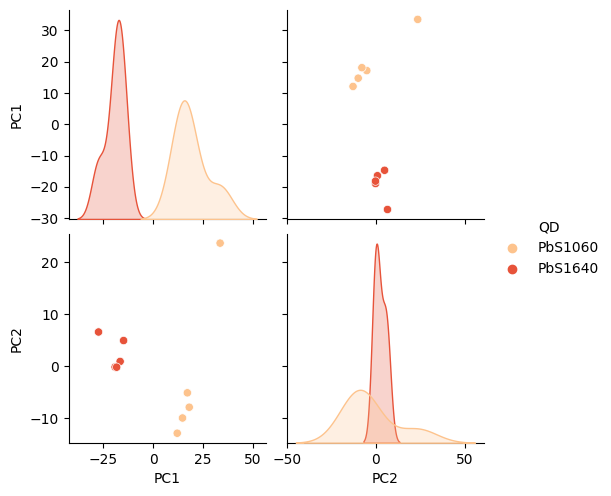

In [9]:
df = pd.DataFrame(Xt2, columns=['PC1', 'PC2'])
#df = pd.DataFrame(Xt2, columns=['PC1', 'PC2', 'PC3'])

df["QD"] = lab.T.astype("int")
df['QD'] = df['QD'].replace([0], 'PbS1060')
df['QD'] = df['QD'].replace([1], 'PbS1640')
sns.pairplot(df, hue="QD", palette='OrRd')
plt.show()

## обучение-классификация с нарушениями

Теперь нас есть преобразованный фрейм данных, теперь его по идее можно "обучать и разделять", хотя размер выборки преступно мал, и берем прямо из обучающего набора.

In [10]:
# Fitting Logistic Regression To the training set
classifier = LogisticRegression(random_state = 0)
classifier.fit(Xt2, lab.T.astype("int"))

test = nfeat1[3:7,:] # samples 6 & 7, некорректно из тренировочной базы брать, ну да ладно.

# Predicting the test set result 
X_test = skpca2.transform(test)
y_pred = classifier.predict(X_test)

Одна группа спектров у нас обозначена как "0", другая как "1", и параметр "y_pred" показывает насколько распознаваемый спектр расположен на интервале (0,1) относительно тестовых образцов. Решим что все что больше 0,5 это "1", меньше - "0".

In [11]:
predicts = []
for i in y_pred:
    if i > 0.5:
        predicts.append('PbS1640')
    else:
        predicts.append('PbS1060')

А теперь результаты предсказаний, в численном виде и с конвертацией в тип:

In [12]:
print(y_pred)
print(predicts)

[0 0 1 1]
['PbS1060', 'PbS1060', 'PbS1640', 'PbS1640']


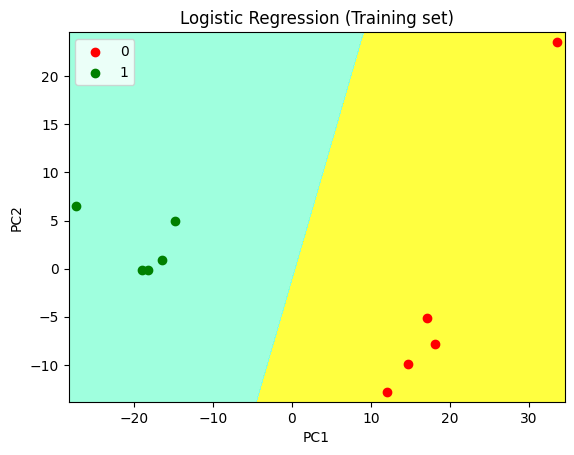

In [13]:
# Predicting the training set result
X_set, y_set = Xt2, lab.T.astype("int")

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
                     stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1,
                     stop = X_set[:, 1].max() + 1, step = 0.01))
  
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(),
             X2.ravel()]).T).reshape(X1.shape), alpha = 0.75,
             cmap = ListedColormap(('yellow', 'white', 'aquamarine')))
  
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
  
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color = ListedColormap(('red', 'green', 'blue'))(i), label = j)

  
plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1') # for Xlabel
plt.ylabel('PC2') # for Ylabel
plt.legend() # to show legend
  
# show scatter plot
plt.show()